# TSG: Traffic Monitor For MDM Disabled SUs

This is a [Trouble Shooting Guide](https://www.bing.com) || 
##### Source : Platform 
Customer_Impact: NO


## Summary

We have disabled the CurrentReqPerSec MDM Health Monitor for three SUs (ax-ea-1, ax-cca-1, ax-sin-1). The reason being these SUs have a very low traffic. So Thus Azure load balancer hits the SUs many times which have low traffic. Thus it creates noise on CurrrentReqPERSecAll  monitor. So this monitor make sense to turn on when there is enough traffic on these again. So we created a kalypso monitor on kusto logs to monitor logs for every week and send an email to Analytics team to turn on the monitor again.




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


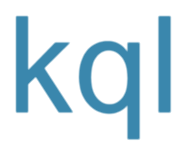

In [1]:
%reload_ext Kqlmagic

In [2]:
%kql AzureDataExplorer://code;cluster='Vso';database='VSO'

In [16]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [17]:
import ipywidgets as widgets
# this Example shows the query for Scale Units and Number of days are variables
# defining some widgets
slider = widgets.IntSlider(
         value=1,
         min=0,
         max=10.0,
         step=1,
    description="days");

menu = widgets.Dropdown(
       options=['ax-ea-1', 'ax-cca-1', 'ax-sin-1'],
       value='ax-ea-1',
       description='Scale Unit')

markdown_out = widgets.Output()
box = widgets.VBox([slider, menu,markdown_out ])


In [18]:
_ScaleUnit_ = "su1"
_days_ = 2;
_SuThresholds_ = '{"ax-ea-1": 16600, "ax-cca-1": 22600, "ax-sin-1":38000}'

### Identifying the SUs out of given SUs with high traffic
Query that return all the SUs with high traffic than the threshold.

In [19]:
%%kql
let SUtoThresholdDictionary = _SuThresholds_;
let thresholds = parsejson(SUtoThresholdDictionary);
ActivityLog
| extend threshold = tolong(thresholds[ScaleUnit])
| where isnotempty(threshold)
| where RoleInstance startswith "AT_IN_"
| where PreciseTimeStamp > ago(1d)
| where Command != 'Health.GetHealth'
| summarize count() by RoleInstance, ScaleUnit, threshold
| where count_ > threshold

RoleInstance,ScaleUnit,threshold,count_
AT_IN_0_Blue,ax-ea-1,16600,235641
AT_IN_2_Green,ax-cca-1,22600,315851
AT_IN_1_Blue,ax-ea-1,16600,228208
AT_IN_0_Green,ax-cca-1,22600,307740
AT_IN_1_Blue,ax-sin-1,38000,262482
AT_IN_2_Blue,ax-sin-1,38000,263592
AT_IN_2_Blue,ax-ea-1,16600,228116
AT_IN_0_Blue,ax-sin-1,38000,261730
AT_IN_1_Green,ax-cca-1,22600,316638
AT_IN_0_Green,ax-ea-1,16600,397824


[{'RoleInstance': 'AT_IN_0_Blue', 'ScaleUnit': 'ax-ea-1', 'threshold': 16600, 'count_': 235641},
 {'RoleInstance': 'AT_IN_2_Green', 'ScaleUnit': 'ax-cca-1', 'threshold': 22600, 'count_': 315851},
 {'RoleInstance': 'AT_IN_1_Blue', 'ScaleUnit': 'ax-ea-1', 'threshold': 16600, 'count_': 228208},
 {'RoleInstance': 'AT_IN_0_Green', 'ScaleUnit': 'ax-cca-1', 'threshold': 22600, 'count_': 307740},
 {'RoleInstance': 'AT_IN_1_Blue', 'ScaleUnit': 'ax-sin-1', 'threshold': 38000, 'count_': 262482},
 {'RoleInstance': 'AT_IN_2_Blue', 'ScaleUnit': 'ax-sin-1', 'threshold': 38000, 'count_': 263592},
 {'RoleInstance': 'AT_IN_2_Blue', 'ScaleUnit': 'ax-ea-1', 'threshold': 16600, 'count_': 228116},
 {'RoleInstance': 'AT_IN_0_Blue', 'ScaleUnit': 'ax-sin-1', 'threshold': 38000, 'count_': 261730},
 {'RoleInstance': 'AT_IN_1_Green', 'ScaleUnit': 'ax-cca-1', 'threshold': 22600, 'count_': 316638},
 {'RoleInstance': 'AT_IN_0_Green', 'ScaleUnit': 'ax-ea-1', 'threshold': 16600, 'count_': 397824},
 {'RoleInstance': 'AT_IN_0_Green', 'ScaleUnit': 'ax-sin-1', 'threshold': 38000, 'count_': 238549},
 {'RoleInstance': 'AT_IN_1_Green', 'ScaleUnit': 'ax-sin-1', 'threshold': 38000, 'count_': 244606},
 {'RoleInstance': 'AT_IN_0_Blue', 'ScaleUnit': 'ax-cca-1', 'threshold': 22600, 'count_': 79043},
 {'RoleInstance': 'AT_IN_1_Blue', 'ScaleUnit': 'ax-cca-1', 'threshold': 22600, 'count_': 80894},
 {'RoleInstance': 'AT_IN_2_Green', 'ScaleUnit': 'ax-sin-1', 'threshold': 38000, 'count_': 235871},
 {'RoleInstance': 'AT_IN_2_Green', 'ScaleUnit': 'ax-ea-1', 'threshold': 16600, 'count_': 395265},
 {'RoleInstance': 'AT_IN_1_Green', 'ScaleUnit': 'ax-ea-1', 'threshold': 16600, 'count_': 389668},
 {'RoleInstance': 'AT_IN_2_Blue', 'ScaleUnit': 'ax-cca-1', 'threshold': 22600, 'count_': 81210}]

## Reason
This monitor is fired when there the traffic is more than the threshold value for the given SUs.
Following are the values that are used for the SUs to trigger the monitor.

Select the values from below menu and run the section to fetch individual data

In [20]:
box

In [21]:
def on_Daysvalue_change(change):
    global _days_;
    _days_ = change['new']

def on_ScaleUnitvalue_change(change):
    global _ScaleUnit_;
    _ScaleUnit_ = change['new']


slider.observe(on_Daysvalue_change, names='value')
menu.observe(on_ScaleUnitvalue_change, names='value')

In [15]:
%%kql
let scaleUnit = _ScaleUnit_;
 ActivityLog
| where ScaleUnit == scaleUnit
| where RoleInstance contains "AT_IN_"
| where PreciseTimeStamp > ago(15d)
| where Command != 'Health.GetHealth'
| summarize count() by  RoleInstance, bin(PreciseTimeStamp, 1d)
| render timechart

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 118, 179)', 'width': 1},
              'name': 'AT_IN_…

[{'RoleInstance': 'AT_IN_2_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 2873998},
 {'RoleInstance': 'AT_IN_22_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1130856},
 {'RoleInstance': 'AT_IN_26_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1999553},
 {'RoleInstance': 'AT_IN_147_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1172681},
 {'RoleInstance': 'AT_IN_10_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1154489},
 {'RoleInstance': 'AT_IN_0_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 2827511},
 {'RoleInstance': 'AT_IN_14_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 2085629},
 {'RoleInstance': 'AT_IN_24_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 2005410},
 {'RoleInstance': 'AT_IN_12_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 10484628},
 {'RoleInstance': 'AT_IN_10_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 10278810},
 {'RoleInstance': 'AT_IN_1_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 20174155},
 {'RoleInstance': 'AT_IN_15_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 2055285},
 {'RoleInstance': 'AT_IN_154_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1127137},
 {'RoleInstance': 'AT_IN_151_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1128792},
 {'RoleInstance': 'AT_IN_150_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1169644},
 {'RoleInstance': 'AT_IN_148_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1161316},
 {'RoleInstance': 'AT_IN_19_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1179585},
 {'RoleInstance': 'AT_IN_16_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1944740},
 {'RoleInstance': 'AT_IN_152_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1194219},
 {'RoleInstance': 'AT_IN_20_Green', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 1169699},
 {'RoleInstance': 'AT_IN_2_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 21223172},
 {'RoleInstance': 'AT_IN_0_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 9310569},
 {'RoleInstance': 'AT_IN_27_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 250243},
 {'RoleInstance': 'AT_IN_15_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 262795},
 {'RoleInstance': 'AT_IN_6_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 7605025},
 {'RoleInstance': 'AT_IN_5_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 19314519},
 {'RoleInstance': 'AT_IN_3_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 8648503},
 {'RoleInstance': 'AT_IN_4_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 18478048},
 {'RoleInstance': 'AT_IN_7_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 18336759},
 {'RoleInstance': 'AT_IN_13_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11, 14, 0, 0, tzinfo=tzutc()), 'count_': 10925082},
 {'RoleInstance': 'AT_IN_8_Blue', 'PreciseTimeStamp': datetime.datetime(2019, 11,

# ToDo

When this monitor is fired, There are two follow up things to do. First one is to tune the threshold value for the respective SUs. If the threshold value is good enough and monitor is fired because there is enough traffic in the SU. Then we need to turn on the CurrentReqPerSec monitor for those SUs again. In order to turn on the monitor again, look into this PR: [Pull Request 313273: Merge users/vabokam/MDMMonitor\_off\_for\_ea\_cca\_sin to master](https://dev.azure.com/mseng/AzureDevOps/_git/AzureDevOps/pullrequest/313273?_a=overview) . For example if we need to enable the CurrentReqPerSec monitor for all the SUs above. We need to revert this PR. But if we need to enable it for subset of SUs of above three, we need to enable to those specific SUs.

# Adding New SU to this list

In order to add a new SU to monitor. First disable the monitor for that SU as shown in this PR: [Pull Request 313273: Merge users/vabokam/MDMMonitor\_off\_for\_ea\_cca\_sin to master](https://dev.azure.com/mseng/AzureDevOps/_git/AzureDevOps/pullrequest/313273?_a=overview) and then come up with a threshold value for that SU, that you should get notified when traffic increases beyond this value. One this threshold value is figured out. Add a key value pair for that SU into the json string input to this monitor.

# Customer Impact

No customer Impact since this only turning on/off of the MDM health monitor.


---

[MDM Health](/Orphaned-pages/MDM-Health)
